In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
data = pd.read_csv(r'C:\Users\Lenovo\Documents\Industrial production Spain monthly.csv')
data.columns = ['t','x']

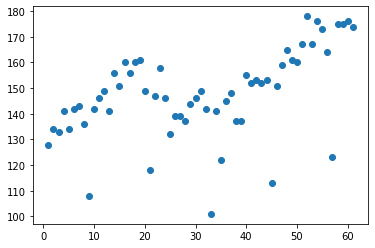

In [10]:
plt.scatter(data.t,data.x)

In [11]:
data.shape

(61, 2)

In [133]:
df = STL(data.x,period=3).fit()
df = data.x

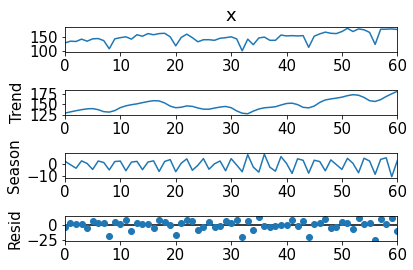

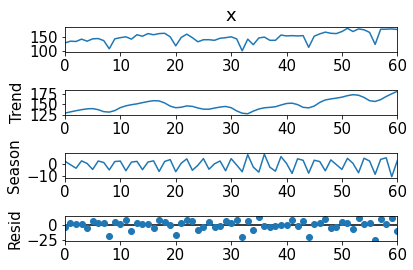

In [120]:
df.plot()

In [135]:
new_x = data.x

In [136]:
new_x

0     128
1     134
2     133
3     141
4     134
     ... 
56    123
57    175
58    175
59    176
60    174
Name: x, Length: 61, dtype: int64

In [137]:
df = new_x

In [138]:
df = pd.concat([pd.Series(list(range(len(new_x)))).astype(int),new_x],axis=1)

In [139]:
df

,0,x
0,0,128
1,1,134
2,2,133
3,3,141
4,4,134
...,...,...
56,56,123
57,57,175
58,58,175
59,59,176


In [140]:

def train_test(df, test_periods):
    train = df[:-test_periods].values
    test = df[-test_periods:].values
    return train, test

test_periods = 12
train, test = train_test(df, test_periods)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[:,1].reshape(-1,1))

train_scaled = torch.FloatTensor(train_scaled)
train_scaled = train_scaled.view(-1)


In [141]:
train

array([[  0, 128],
       [  1, 134],
       [  2, 133],
       [  3, 141],
       [  4, 134],
       [  5, 142],
       [  6, 143],
       [  7, 136],
       [  8, 108],
       [  9, 142],
       [ 10, 146],
       [ 11, 149],
       [ 12, 141],
       [ 13, 156],
       [ 14, 151],
       [ 15, 160],
       [ 16, 156],
       [ 17, 160],
       [ 18, 161],
       [ 19, 149],
       [ 20, 118],
       [ 21, 147],
       [ 22, 158],
       [ 23, 146],
       [ 24, 132],
       [ 25, 139],
       [ 26, 139],
       [ 27, 137],
       [ 28, 144],
       [ 29, 146],
       [ 30, 149],
       [ 31, 142],
       [ 32, 101],
       [ 33, 141],
       [ 34, 122],
       [ 35, 145],
       [ 36, 148],
       [ 37, 137],
       [ 38, 137],
       [ 39, 155],
       [ 40, 152],
       [ 41, 153],
       [ 42, 152],
       [ 43, 153],
       [ 44, 113],
       [ 45, 151],
       [ 46, 159],
       [ 47, 165],
       [ 48, 161]], dtype=int64)

In [144]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]

    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)

    return x_train, y_train

train_periods = 12 #-- number of quarters for input
prediction_periods = test_periods
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)
torch.Size([11, 16])
torch.Size([11, 8])

torch.Size([25, 12])
torch.Size([25, 12])


torch.Size([11, 8])

In [145]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size),
                           torch.zeros(1,1,self.hidden_size))
        else:
            self.hidden = hidden

        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1),
                                          self.hidden)

        predictions = self.linear(lstm_out.view(len(x), -1))

        return predictions[-1], self.hidden

In [146]:
model = LSTM(input_size=1, hidden_size=50, output_size=test_periods)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 300
model.train()
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

model.eval()
with torch.no_grad():
    predictions, _ = model(train_scaled[-train_periods:], None)
predictions = scaler.inverse_transform(np.array(predictions.reshape(-1,1)))

epoch:    0 loss:0.36127338
epoch:  100 loss:0.05123280
epoch:  200 loss:0.00791215
epoch:  300 loss:0.00249959


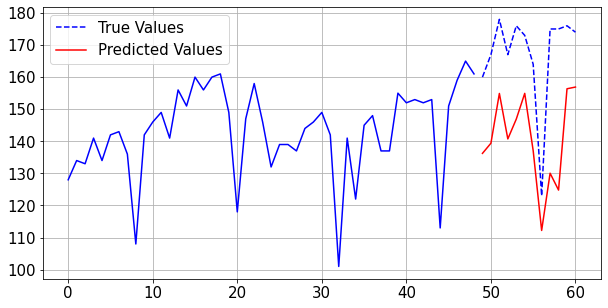

In [148]:
x = df.index
font = {'size'   : 15}

mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(x[:-len(predictions)],
         df.x[:-len(predictions)],
         "b-")
plt.plot(x[-len(predictions):],
         df.x[-len(predictions):],
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)
